In [1]:

import pickle as pk
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import os


os.getcwd()

'/home/ubuntu/LTEE/exploratory_code'

In [2]:
#pickled captum feature ablation output
in_data = pk.load(open('../g_p_attr_individual_pheno.pk','rb'))

#read in input into model to get labels of input features
loci = pd.read_csv('../annotated_output_presence_absence_only.txt', sep='\s+')
loci2 = loci.iloc[:, :1]
del loci

#linear model reference
linear_mod = pd.read_csv('../presabs_marker_effects_probit.txt', sep='\t')


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_416241/4221682966.py:5: SyntaxWarning: invalid escape sequence '\s'
  loci = pd.read_csv('../annotated_output_presence_absence_only.txt', sep='\s+')


In [3]:
linear_mod

,chr,gene,eff_ampicillin,eff_trimethoprim.sulfamethoxazole,eff_cefotaxime,eff_ceftazidime,eff_ciprofloxacin,rank_ampicillin,rank_trimethoprim.sulfamethoxazole,rank_cefotaxime,rank_ceftazidime,rank_ciprofloxacin
0,Cluster_6325_+_+_GCA_003333945.1_ASM333394v1_+...,NaN,0.048361,0.003381,0.003889,0.003470,0.000271,1.0,221.0,176.0,227.0,16474.0
1,Cluster_7829_+_+_GCA_003334785.1_ASM333478v1_+...,NaN,0.048335,0.003488,0.006753,0.003985,0.002871,2.0,198.0,8.0,106.0,690.0
2,MFCAOJAD_04226presabs,bla,0.039358,0.002902,0.005690,0.003938,0.001796,3.0,404.0,27.0,111.0,2876.0
3,MFCAOJAD_04228presabs,group_13207,0.038891,0.001352,0.022095,0.020161,0.005409,4.0,3549.0,1.0,1.0,20.0
4,Cluster_10358_+_+_GCA_003333945.1_ASM333394v1_...,NaN,0.000894,0.036217,0.003204,0.003178,0.001440,8434.0,1.0,441.0,346.0,4532.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21179,ONLNHHCL_01846presabs,dgcZ_1,NaN,0.000014,NaN,NaN,NaN,NaN,20412.0,NaN,NaN,NaN
21180,Cluster_7794_+_+_GCA_003334535.1_ASM333453v1_+...,NaN,NaN,0.000013,NaN,NaN,NaN,NaN,20431.0,NaN,NaN,NaN
21181,Cluster_5356_+_+_GCA_003334535.1_ASM333453v1_+...,NaN,NaN,0.000011,NaN,NaN,NaN,NaN,20470.0,NaN,NaN,NaN
21182,KKBBHFJK_00108presabs,group_11083,0.000002,0.000001,NaN,NaN,NaN,20529.0,20659.0,NaN,NaN,NaN


In [4]:
#batch = in_data[0] #select one batch

batch = []
master_df = pd.DataFrame()
for i in range(len(in_data)):
    batch = in_data[i] #select data from one batch
    batch_pheno_catch = np.empty((0, 32441))
    for pheno in range(5):
        #print(pheno)
        batch_pheno = batch[pheno::5] #select one pheno
        batch_catch = []

        for sample in range(len(batch_pheno)):
            batch_pheno_sample = batch_pheno[sample] #subset to sample (shape = 1 sample * nloci * nalleles)
            #calculate overall allelic effect (sum) at site across 3 alleles (shape = nsamples * nloci)
            batch_pheno_sample_allele = [np.sum(batch_pheno_sample[i:i+3]) for i in range(0, len(batch_pheno_sample), 3)]
            batch_catch += batch_pheno_sample_allele

        #reshape so each sample is one sub-array n-loci long (shape = nsamples * (nloci))
        batch_catch_reshaped = np.array(batch_catch).reshape(-1, 32441)
        #calculate mean for each locus across all samples in batch (shape = nloci)
        column_means = np.mean(batch_catch_reshaped, axis=0)
        batch_pheno_catch =np.vstack((batch_pheno_catch, column_means.T))

        dff = pd.DataFrame(batch_pheno_catch).T
        dff['batch'] = i

    master_df = pd.concat([master_df, dff], axis=0, ignore_index=True)
    # Assign a row index within each batch
    master_df['row_index'] = master_df.groupby('batch').cumcount()
    # Reshape the data for aggregation
    reshaped = master_df.melt(id_vars=['batch', 'row_index'], var_name='column', value_name='value')
    # Calculate the mean for each (row_index, column) pair across batches
    result = reshaped.groupby(['row_index', 'column'])['value'].mean().unstack()

result.to_pickle('feature_ablation_summary_per_pheno.pk')

#column_means_df = pd.DataFrame(column_means)


In [5]:
#precomputed feature ablation summaries per phenotype
result = pk.load(open('feature_ablation_summary_per_pheno.pk','rb'))
print(len(result))


merged_df = pd.concat([result, loci2], axis=1)
print(merged_df.head())


32441
              0         1             2             3             4  \
0  8.130324e-06  0.000037  1.445692e-06  1.228001e-07  6.202316e-07   
1 -7.427634e-06 -0.000017 -4.229668e-07  2.227074e-07 -1.134455e-08   
2 -2.868359e-07  0.000111  5.217629e-07  1.467724e-07  5.041068e-07   
3 -5.061123e-06  0.000054 -7.657266e-07 -5.731934e-07 -1.069969e-06   
4 -1.165043e-05  0.000008 -1.195748e-06  3.190565e-07 -4.625631e-07   

                      ID  
0  LMHECDEF_00001presabs  
1  LMHECDEF_00002presabs  
2  LMHECDEF_00003presabs  
3  LMHECDEF_00004presabs  
4  LMHECDEF_00005presabs  


In [6]:

data_full = pd.merge(merged_df, linear_mod, left_on='ID', right_on='chr', how='inner')

data_full.head()


,0,1,2,3,4,ID,chr,gene,eff_ampicillin,eff_trimethoprim.sulfamethoxazole,eff_cefotaxime,eff_ceftazidime,eff_ciprofloxacin,rank_ampicillin,rank_trimethoprim.sulfamethoxazole,rank_cefotaxime,rank_ceftazidime,rank_ciprofloxacin
0,8.130324e-06,0.000037,1.445692e-06,1.228001e-07,6.202316e-07,LMHECDEF_00001presabs,LMHECDEF_00001presabs,group_756,0.000197,0.001385,0.000576,0.000285,0.000797,17268.0,3370.0,11690.0,15693.0,9625.0
1,-7.427634e-06,-0.000017,-4.229668e-07,2.227074e-07,-1.134455e-08,LMHECDEF_00002presabs,LMHECDEF_00002presabs,group_854,0.000363,0.000112,0.000153,0.000213,0.000280,14845.0,18553.0,17814.0,16919.0,16322.0
2,-2.868359e-07,0.000111,5.217629e-07,1.467724e-07,5.041068e-07,LMHECDEF_00003presabs,LMHECDEF_00003presabs,group_1295,0.000746,0.000800,0.000060,0.000576,0.000936,9935.0,7738.0,19328.0,11117.0,8196.0
3,-5.061123e-06,0.000054,-7.657266e-07,-5.731934e-07,-1.069969e-06,LMHECDEF_00004presabs,LMHECDEF_00004presabs,group_445,0.002909,0.001802,0.001098,0.001089,0.000343,730.0,1863.0,6378.0,5844.0,15382.0
4,-1.165043e-05,0.000008,-1.195748e-06,3.190565e-07,-4.625631e-07,LMHECDEF_00005presabs,LMHECDEF_00005presabs,group_8480,0.000184,0.000323,0.001583,0.000708,0.000793,17490.0,14556.0,3551.0,9464.0,9674.0


In [7]:
for i in range(5):
    data_full[str(i)+"rank"] = data_full[i].abs().rank(ascending=True)
data_full

,0,1,2,3,4,ID,chr,gene,eff_ampicillin,eff_trimethoprim.sulfamethoxazole,...,rank_ampicillin,rank_trimethoprim.sulfamethoxazole,rank_cefotaxime,rank_ceftazidime,rank_ciprofloxacin,0rank,1rank,2rank,3rank,4rank
0,8.130324e-06,0.000037,1.445692e-06,1.228001e-07,6.202316e-07,LMHECDEF_00001presabs,LMHECDEF_00001presabs,group_756,0.000197,0.001385,...,17268.0,3370.0,11690.0,15693.0,9625.0,12377.0,10126.0,16433.0,3388.0,11293.0
1,-7.427634e-06,-0.000017,-4.229668e-07,2.227074e-07,-1.134455e-08,LMHECDEF_00002presabs,LMHECDEF_00002presabs,group_854,0.000363,0.000112,...,14845.0,18553.0,17814.0,16919.0,16322.0,11496.0,4992.0,6037.0,6064.0,203.0
2,-2.868359e-07,0.000111,5.217629e-07,1.467724e-07,5.041068e-07,LMHECDEF_00003presabs,LMHECDEF_00003presabs,group_1295,0.000746,0.000800,...,9935.0,7738.0,19328.0,11117.0,8196.0,539.0,19882.0,7352.0,4059.0,9487.0
3,-5.061123e-06,0.000054,-7.657266e-07,-5.731934e-07,-1.069969e-06,LMHECDEF_00004presabs,LMHECDEF_00004presabs,group_445,0.002909,0.001802,...,730.0,1863.0,6378.0,5844.0,15382.0,8289.0,13629.0,10238.0,13657.0,16678.0
4,-1.165043e-05,0.000008,-1.195748e-06,3.190565e-07,-4.625631e-07,LMHECDEF_00005presabs,LMHECDEF_00005presabs,group_8480,0.000184,0.000323,...,17490.0,14556.0,3551.0,9464.0,9674.0,16000.0,2420.0,14570.0,8440.0,8786.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21179,1.556768e-05,-0.000033,1.589120e-06,-5.708525e-07,8.319093e-07,Cluster_1709_+_+_GCA_003335465.1_ASM333546v1_+...,Cluster_1709_+_+_GCA_003335465.1_ASM333546v1_+...,NaN,0.003180,0.000099,...,516.0,18819.0,6289.0,3752.0,6413.0,18531.0,9051.0,17341.0,13623.0,14188.0
21180,1.204911e-05,0.000010,1.507234e-06,-3.146933e-07,3.851016e-07,Cluster_12752_+_+_GCA_003335465.1_ASM333546v1_...,Cluster_12752_+_+_GCA_003335465.1_ASM333546v1_...,NaN,0.000383,0.000018,...,14553.0,20335.0,4825.0,17328.0,9258.0,16317.0,2830.0,16858.0,8336.0,7390.0
21181,1.100835e-05,0.000042,9.012879e-07,2.292423e-07,6.779148e-07,Cluster_8652_+_+_GCA_003335465.1_ASM333546v1_+...,Cluster_8652_+_+_GCA_003335465.1_ASM333546v1_+...,NaN,0.001836,0.000251,...,2780.0,15956.0,11932.0,20111.0,7285.0,15447.0,11140.0,11744.0,6224.0,12146.0
21182,3.624853e-06,0.000049,-2.486216e-07,-1.792834e-07,-1.018348e-06,Cluster_11439_+_+_GCA_003335465.1_ASM333546v1_...,Cluster_11439_+_+_GCA_003335465.1_ASM333546v1_...,NaN,0.001950,0.001366,...,2377.0,3470.0,16290.0,5733.0,6029.0,6162.0,12703.0,3693.0,4934.0,16186.0


Text(0.5, 1.0, 'ceftazidime')

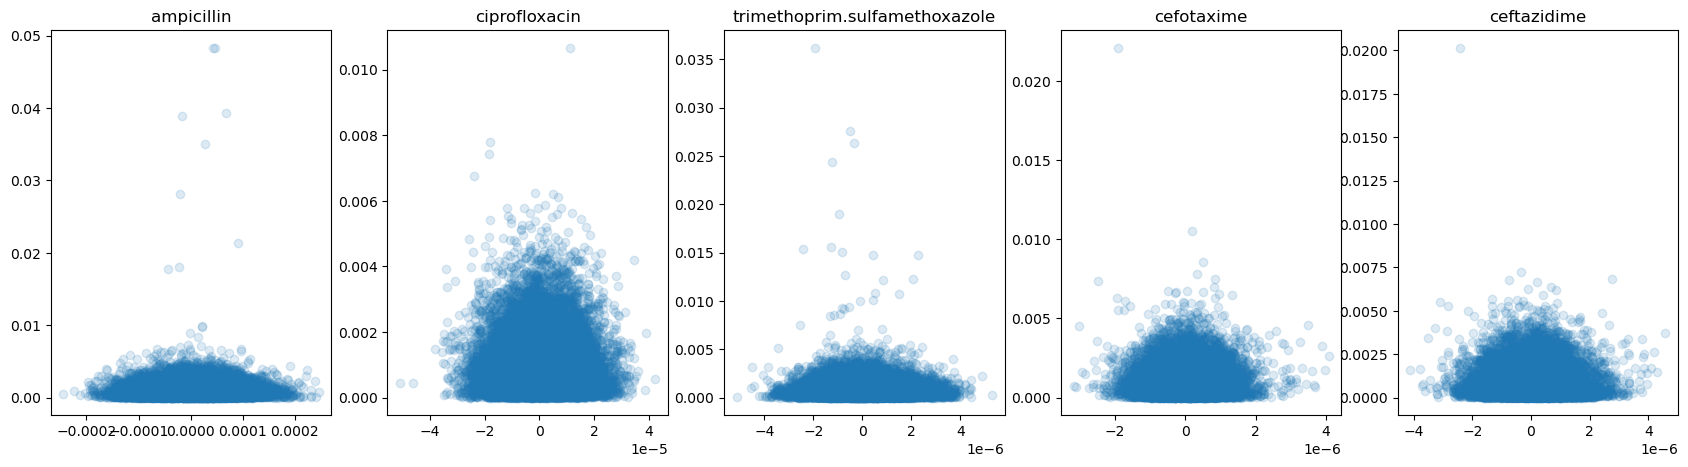

In [8]:

plt.figure(figsize=(21, 5))


plt.subplot(1, 5, 1)  # row 1, column 2, count 1
plt.scatter(data_full[1], data_full['eff_ampicillin'],alpha=0.15)
plt.title('ampicillin')

plt.subplot(1, 5, 2)
plt.scatter(data_full[0], data_full['eff_ciprofloxacin'],alpha=0.15)
plt.title('ciprofloxacin')

plt.subplot(1, 5, 3)
plt.scatter(data_full[2], data_full['eff_trimethoprim.sulfamethoxazole'],alpha=0.15)
plt.title('trimethoprim.sulfamethoxazole')

plt.subplot(1, 5, 4)
plt.scatter(data_full[3], data_full['eff_cefotaxime'],alpha=0.15)
plt.title('cefotaxime')

plt.subplot(1, 5, 5)
plt.scatter(data_full[4], data_full['eff_ceftazidime'],alpha=0.15)
plt.title('ceftazidime')


Text(0.5, 1.0, 'ceftazidime')

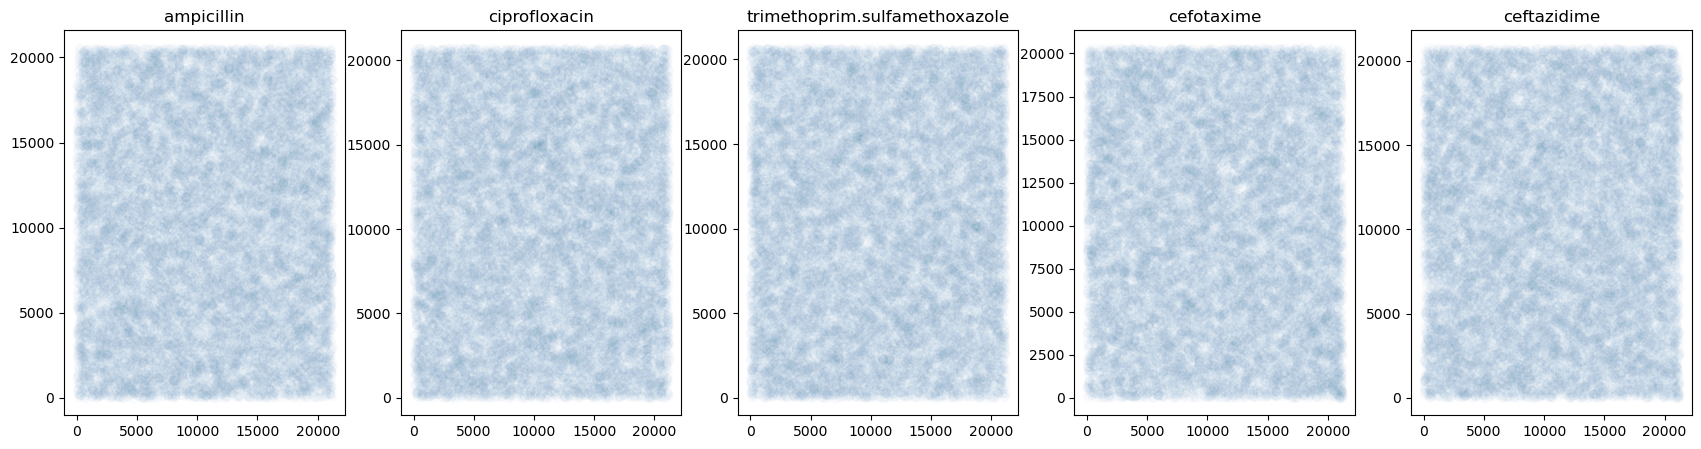

In [18]:
plt.figure(figsize=(21, 5))


plt.subplot(1, 5, 1)  # row 1, column 2, count 1
plt.scatter(data_full['1rank'], data_full['rank_ampicillin'],alpha=0.01)
plt.title('ampicillin')

plt.subplot(1, 5, 2)
plt.scatter(data_full['0rank'], data_full['rank_ciprofloxacin'],alpha=0.01)
plt.title('ciprofloxacin')

plt.subplot(1, 5, 3)
plt.scatter(data_full['2rank'], data_full['rank_trimethoprim.sulfamethoxazole'],alpha=0.01)
plt.title('trimethoprim.sulfamethoxazole')

plt.subplot(1, 5, 4)
plt.scatter(data_full['3rank'], data_full['rank_cefotaxime'],alpha=0.01)
plt.title('cefotaxime')

plt.subplot(1, 5, 5)
plt.scatter(data_full['4rank'], data_full['rank_ceftazidime'],alpha=0.01)
plt.title('ceftazidime')

(0.0, 1000.0)

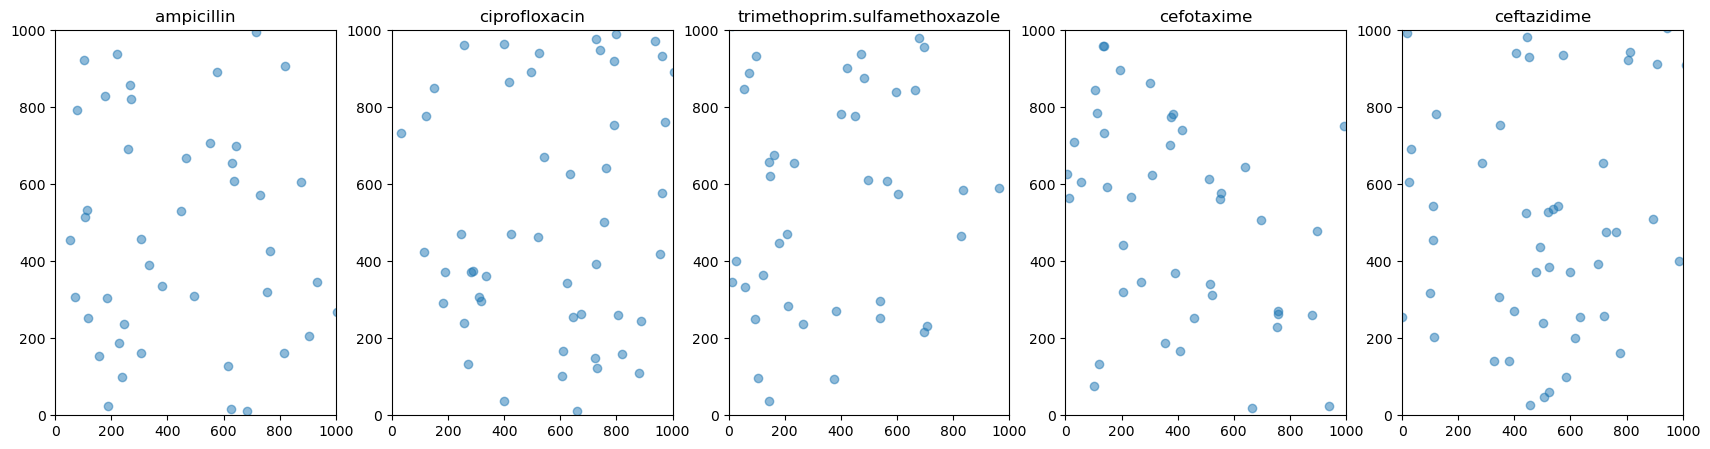

In [10]:
plt.figure(figsize=(21, 5))


plt.subplot(1, 5, 1)  # row 1, column 2, count 1
plt.scatter(data_full['1rank'], data_full['rank_ampicillin'],alpha=0.5)
plt.title('ampicillin')
ax = plt.gca()
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])

plt.subplot(1, 5, 2)
plt.scatter(data_full['0rank'], data_full['rank_ciprofloxacin'],alpha=0.5)
plt.title('ciprofloxacin')
ax = plt.gca()
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])

plt.subplot(1, 5, 3)
plt.scatter(data_full['2rank'], data_full['rank_trimethoprim.sulfamethoxazole'],alpha=0.5)
plt.title('trimethoprim.sulfamethoxazole')
ax = plt.gca()
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])

plt.subplot(1, 5, 4)
plt.scatter(data_full['3rank'], data_full['rank_cefotaxime'],alpha=0.5)
plt.title('cefotaxime')
ax = plt.gca()
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])

plt.subplot(1, 5, 5)
plt.scatter(data_full['4rank'], data_full['rank_ceftazidime'],alpha=0.5)
plt.title('ceftazidime')
ax = plt.gca()
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])

Text(0.5, 1.0, 'ceftazidime')

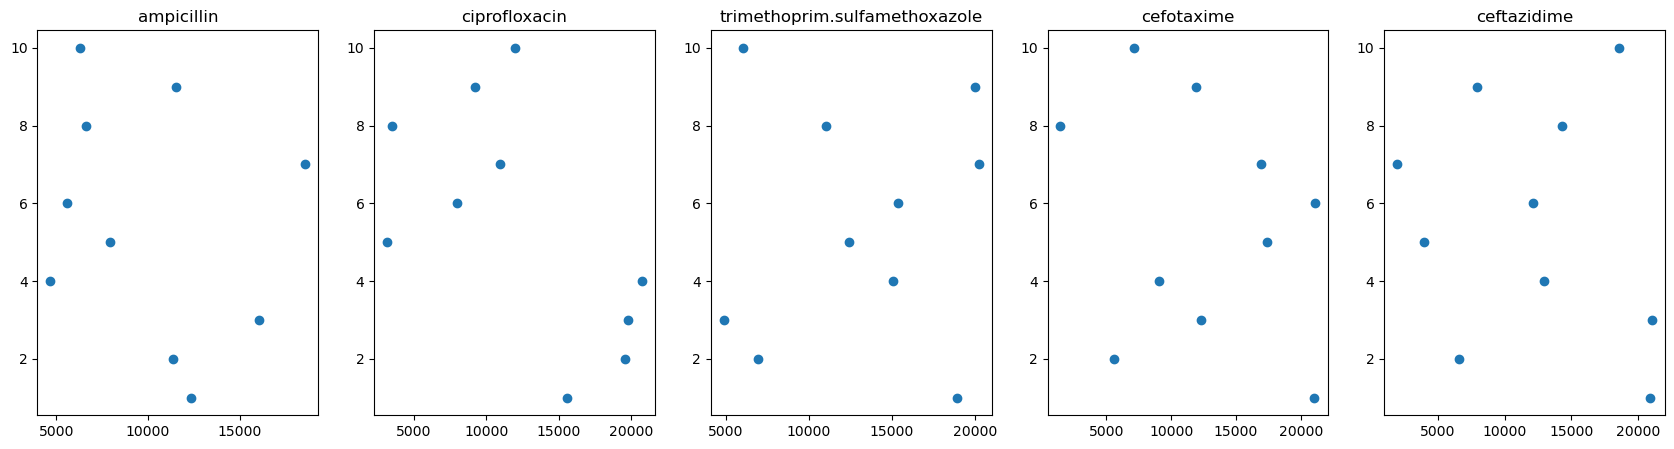

In [11]:
#subset_df = data_full[data_full['rank_ampicillin'] < 11]
#plt.scatter(subset_df['marker_rank'], subset_df['rank_ampicillin'])

#plotting the comparative rank of only the top largest effect linear model markers

plt.figure(figsize=(21, 5))


plt.subplot(1, 5, 1)  # row 1, column 2, count 1
subset_df = data_full[data_full['rank_ampicillin'] < 11]
plt.scatter(subset_df['1rank'], subset_df['rank_ampicillin'])
plt.title('ampicillin')

plt.subplot(1, 5, 2)
subset_df = data_full[data_full['rank_ciprofloxacin'] < 11]
plt.scatter(subset_df['0rank'], subset_df['rank_ciprofloxacin'])
plt.title('ciprofloxacin')


plt.subplot(1, 5, 3)
subset_df = data_full[data_full['rank_trimethoprim.sulfamethoxazole'] < 11]
plt.scatter(subset_df['2rank'], subset_df['rank_trimethoprim.sulfamethoxazole'])
plt.title('trimethoprim.sulfamethoxazole')

plt.subplot(1, 5, 4)
subset_df = data_full[data_full['rank_cefotaxime'] < 11]
plt.scatter(subset_df['3rank'], subset_df['rank_cefotaxime'])
plt.title('cefotaxime')


plt.subplot(1, 5, 5)
subset_df = data_full[data_full['rank_ceftazidime'] < 11]
plt.scatter(subset_df['4rank'], subset_df['rank_ceftazidime'])
plt.title('ceftazidime')


In [12]:
#can use to visualuze latent space
in_data3 = pk.load(open("../phens_phen_encodings_dng_gp.pk",'rb'))

#test phens 1409 * 5
in_data3[0]


array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Text(0.5, 0, 'real')

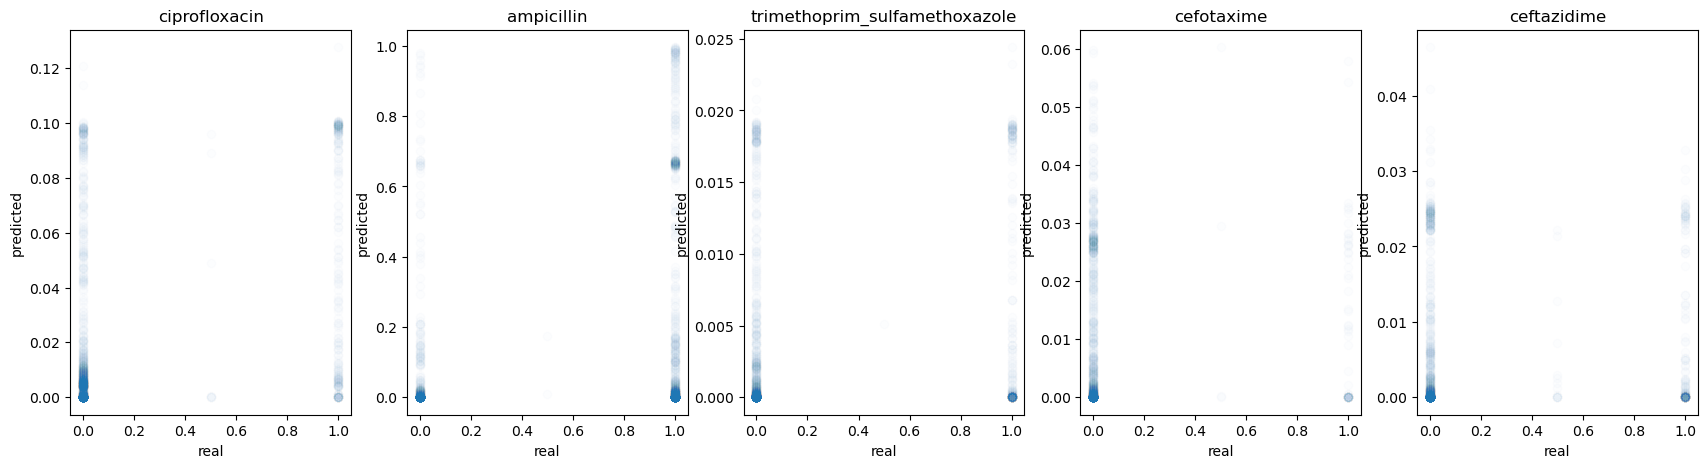

In [13]:


#phenotypes, phenotype encodings and pheno latent from G-P model
#can use to visualuze latent space
in_data3 = pk.load(open("../phens_phen_encodings_dng_gp.pk",'rb'))

#test phens 1409 * 5
in_data3[0]
len(in_data3[0])
#len(in_data3[0][0])

#test phens decodded(?) 1409 * 5
in_data3[1]
len(in_data3[1])
#len(in_data3[1][0])

#test phens latent 1409 * 4
in_data3[2]
len(in_data3[2])
#len(in_data3[1][0])

################
raw_pheno = in_data3[0]



raw_pheno = pd.DataFrame(in_data3[0].T, columns=['ciprofloxacin', 'ampicillin',
                'trimethoprim_sulfamethoxazole', 'cefotaxime', 'ceftazidime'])

raw_pheno
#raw_pheno.sum(axis=1)

pred_pheno = pd.DataFrame(in_data3[1].T, columns=['ciprofloxacin', 'ampicillin',
                'trimethoprim_sulfamethoxazole', 'cefotaxime', 'ceftazidime'])
pred_pheno


#create new max abs value variable
#df['max_eff'] = df[['allele0', 'allele1', 'allele2']].abs().max(axis=1)


plt.figure(figsize=(21, 5))


plt.subplot(1, 5, 1)  # row 1, column 2, count 1
plt.scatter(raw_pheno['ciprofloxacin'], pred_pheno['ciprofloxacin'],alpha=0.01)
plt.title('ciprofloxacin')
plt.ylabel("predicted")
plt.xlabel("real")


plt.subplot(1, 5, 2)  # row 1, column 2, count 1
plt.scatter(raw_pheno['ampicillin'], pred_pheno['ampicillin'],alpha=0.01)
plt.title('ampicillin')
plt.ylabel("predicted")
plt.xlabel("real")


plt.subplot(1, 5, 3)  # row 1, column 2, count 1
plt.scatter(raw_pheno['trimethoprim_sulfamethoxazole'], pred_pheno['trimethoprim_sulfamethoxazole'],alpha=0.01)
plt.title('trimethoprim_sulfamethoxazole')
plt.ylabel("predicted")
plt.xlabel("real")

plt.subplot(1, 5, 4)  # row 1, column 2, count 1
plt.scatter(raw_pheno['cefotaxime'], pred_pheno['cefotaxime'],alpha=0.01)
plt.title('cefotaxime')
plt.ylabel("predicted")
plt.xlabel("real")

plt.subplot(1, 5, 5)  # row 1, column 2, count 1
plt.scatter(raw_pheno['ceftazidime'], pred_pheno['ceftazidime'],alpha=0.01)
plt.title('ceftazidime')
plt.ylabel("predicted")
plt.xlabel("real")


In [14]:

r_squared = r2_score(raw_pheno["ciprofloxacin"], pred_pheno["ciprofloxacin"])
print(r_squared, "ciprofloxacin")

r_squared = r2_score(raw_pheno["ampicillin"], pred_pheno["ampicillin"])
print(r_squared, "ampicillin")

r_squared = r2_score(raw_pheno["trimethoprim_sulfamethoxazole"], pred_pheno["trimethoprim_sulfamethoxazole"])
print(r_squared, "trimethoprim_sulfamethoxazole")

r_squared = r2_score(raw_pheno["cefotaxime"], pred_pheno["cefotaxime"])
print(r_squared, "cefotaxime")

r_squared = r2_score(raw_pheno["ceftazidime"], pred_pheno["ceftazidime"])
print(r_squared, "ceftazidime")



from scipy.stats import pearsonr
r, _ = pearsonr(raw_pheno["ciprofloxacin"], pred_pheno["ciprofloxacin"])
r_squared = r**2
print(r_squared)


r, _ = pearsonr(raw_pheno["ampicillin"], pred_pheno["ampicillin"])
r_squared = r**2
print(r_squared)

r, _ = pearsonr(raw_pheno["trimethoprim_sulfamethoxazole"], pred_pheno["trimethoprim_sulfamethoxazole"])
r_squared = r**2
print(r_squared)

r, _ = pearsonr(raw_pheno["cefotaxime"], pred_pheno["cefotaxime"])
r_squared = r**2
print(r_squared)

r, _ = pearsonr(raw_pheno["ceftazidime"], pred_pheno["ceftazidime"])
r_squared = r**2
print(r_squared)

-0.06890809535980225 ciprofloxacin
-0.8217319250106812 ampicillin
-0.1559683084487915 trimethoprim_sulfamethoxazole
-0.020009398460388184 cefotaxime
-0.10743129253387451 ceftazidime
0.16795447740426295
0.06117987414661765
0.08251550937697637
0.016664495094344936
0.03210097882965713


In [15]:
pred_pheno["rounded_ampicillin"] = (pred_pheno["ampicillin"] / 0.5).round() * 0.5
pred_pheno["rounded_ciprofloxacin"] = (pred_pheno["ciprofloxacin"] / 0.5).round() * 0.5
pred_pheno["rounded_trimethoprim_sulfamethoxazole"] = (pred_pheno["trimethoprim_sulfamethoxazole"] / 0.5).round() * 0.5
pred_pheno["rounded_cefotaxime"] = (pred_pheno["cefotaxime"] / 0.5).round() * 0.5

contingency_table = pd.crosstab(raw_pheno["ampicillin"], pred_pheno["rounded_ampicillin"])
print('\n',contingency_table)

contingency_table = pd.crosstab(raw_pheno["ciprofloxacin"], pred_pheno["rounded_ciprofloxacin"])
print('\n',contingency_table)


contingency_table = pd.crosstab(raw_pheno["cefotaxime"], pred_pheno["rounded_cefotaxime"])
print('\n',contingency_table)


 rounded_ampicillin  0.0  0.5  1.0
ampicillin                       
0.0                 557   30   10
0.5                   2    0    0
1.0                 615  117   78

 rounded_ciprofloxacin   0.0
ciprofloxacin              
0.0                    1198
0.5                       8
1.0                     203

 rounded_cefotaxime   0.0
cefotaxime              
0.0                 1349
0.5                    4
1.0                   56


Text(0.5, 0, 'real')

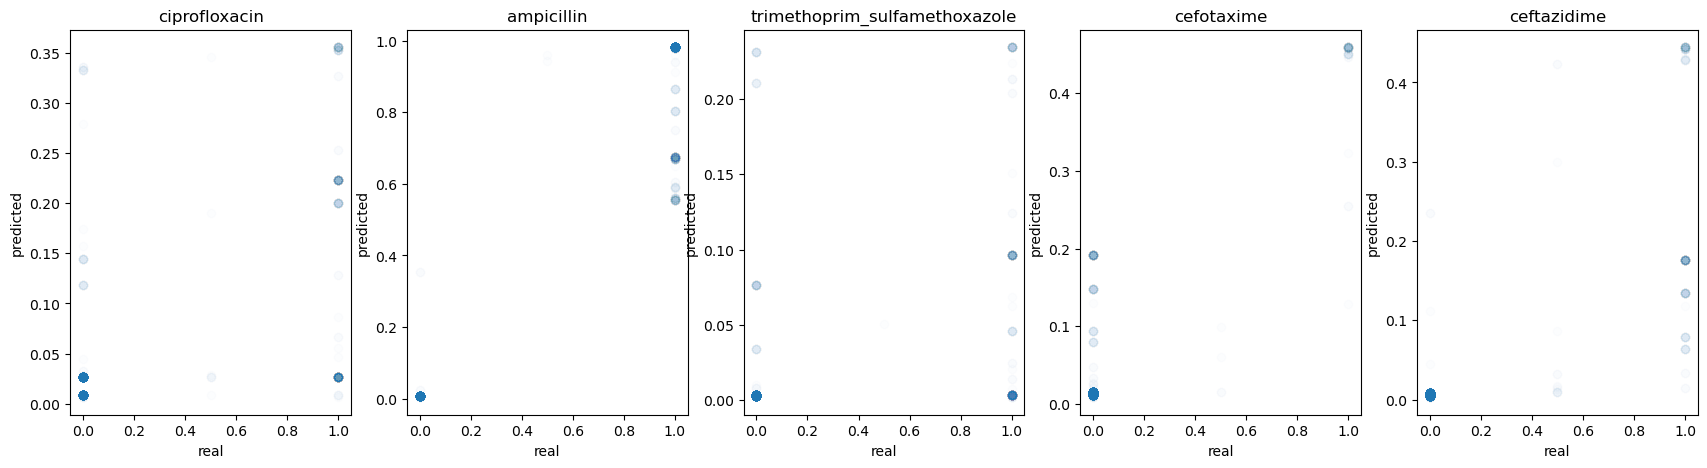

In [16]:
#pheno to pheno pkdump

in_data2 = pk.load(open("../phens_phen_encodings_dng_attr_p.pk",'rb'))

len(in_data2)

in_data2[0]
len(in_data2[0])
len(in_data2[0][0])






raw_pheno_pp = in_data2[0]



raw_pheno_pp = pd.DataFrame(in_data2[0].T, columns=['ciprofloxacin', 'ampicillin',
                'trimethoprim_sulfamethoxazole', 'cefotaxime', 'ceftazidime'])

raw_pheno_pp
#raw_pheno.sum(axis=1)

pred_pheno_pp = pd.DataFrame(in_data2[1].T, columns=['ciprofloxacin', 'ampicillin',
                'trimethoprim_sulfamethoxazole', 'cefotaxime', 'ceftazidime'])
pred_pheno_pp


#create new max abs value variable
#df['max_eff'] = df[['allele0', 'allele1', 'allele2']].abs().max(axis=1)


plt.figure(figsize=(21, 5))


plt.subplot(1, 5, 1)  # row 1, column 2, count 1
plt.scatter(raw_pheno_pp['ciprofloxacin'], pred_pheno_pp['ciprofloxacin'],alpha=0.01)
plt.title('ciprofloxacin')
plt.ylabel("predicted")
plt.xlabel("real")



plt.subplot(1, 5, 2)  # row 1, column 2, count 1
plt.scatter(raw_pheno_pp['ampicillin'], pred_pheno_pp['ampicillin'],alpha=0.01)
plt.title('ampicillin')
plt.ylabel("predicted")
plt.xlabel("real")


plt.subplot(1, 5, 3)  # row 1, column 2, count 1
plt.scatter(raw_pheno_pp['trimethoprim_sulfamethoxazole'], pred_pheno_pp['trimethoprim_sulfamethoxazole'],alpha=0.01)
plt.title('trimethoprim_sulfamethoxazole')
plt.ylabel("predicted")
plt.xlabel("real")

plt.subplot(1, 5, 4)  # row 1, column 2, count 1
plt.scatter(raw_pheno_pp['cefotaxime'], pred_pheno_pp['cefotaxime'],alpha=0.01)
plt.title('cefotaxime')
plt.ylabel("predicted")
plt.xlabel("real")

plt.subplot(1, 5, 5)  # row 1, column 2, count 1
plt.scatter(raw_pheno_pp['ceftazidime'], pred_pheno_pp['ceftazidime'],alpha=0.01)
plt.title('ceftazidime')
plt.ylabel("predicted")
plt.xlabel("real")


In [17]:
r_squared = r2_score(raw_pheno_pp["ciprofloxacin"], pred_pheno_pp["ciprofloxacin"])
print(r_squared, "ciprofloxacin")

r_squared = r2_score(raw_pheno_pp["ampicillin"], pred_pheno_pp["ampicillin"])
print(r_squared, "ampicillin")

r_squared = r2_score(raw_pheno_pp["trimethoprim_sulfamethoxazole"], pred_pheno_pp["trimethoprim_sulfamethoxazole"])
print(r_squared, "trimethoprim_sulfamethoxazole")

r_squared = r2_score(raw_pheno_pp["cefotaxime"], pred_pheno_pp["cefotaxime"])
print(r_squared, "cefotaxime")

r_squared = r2_score(raw_pheno_pp["ceftazidime"], pred_pheno_pp["ceftazidime"])
print(r_squared, "ceftazidime")

0.13947206735610962 ciprofloxacin
0.9440169930458069 ampicillin
-0.035741448402404785 trimethoprim_sulfamethoxazole
0.6137009859085083 cefotaxime
0.3228732943534851 ceftazidime
